## Week 4: Collaborative Filtering & Playing with Climate Embeddings

In this workbook we will focus on the concept of embeddings and look at two very machine learning methods that use embeddings: collaborative filtering and autoencoders.  Embeddings are how machine learning models represent data in a structured way, largely through reducing high dimensional data into continuous vectors.

### Part 1: Collaborative Filtering

When you are shopping online or watching content on streaming services, have you ever thought about how other items or shows are recommended to you? These suggestions are largely due to Recommender systems, which are a way of suggesting similar content to a user's specific preferences.  A common method in Recommender systems is Collaborative Filtering, which recommends content based on similarity measures between users and the content.  In Collaborative Filtering a simple approach is to rely on matrix factorization to identify the relationships between items and user entities. Latent features, the association between users and item matrices, are determine to find similarity and make predictions. Common examples of Collaborative Filtering include the movie or song/artist recommendations from the MovieLens or lastfm datasets, examples of which you can find online.

  For this workbook, we will be focusing on a dataset which features 50+ agricultural commodities grown in over 3200+ administrative units around the world. This data is implicit so we only know if a commodity is grown or not in each location. Imagine you are a policymaker in the agriculture sector and you want to improve nutritional and food security outcomes by improving crop diversity, that is, increasing the number of commodities grown in all the administrative units around the world.  To make these recommendations you would need to understand context-specific information on what crops grow best where and what part of world can grow different crops, but this might be information that you can't easily access.  Instead, for an initial understanding we can use our data to build a recommender system to answer the following questions:
  1. What commodities are most similar to one another?
2. What admin units are most similar to one another?
3. What are the top 5 new commodities that we could recommend for an admin unit to grow?

By the end of this exercise we  will have developed 3 outputs: A similarity matrix of commodities, a similarity matrix of admin units and lastly, a recommendation of the top 5 new commodities for each admin unit in our dataset.

#### Part 1A: Crop-Crop Similarities
Let's load the data and inspect it

In [219]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import seaborn as sns 
import matplotlib.pyplot as plt 


In [220]:
data = pd.read_csv('commoditiesgrown_byadmin1unit.csv')  
data.head()

,admin_id,commodity,grown
0,AFG.1_1,Apples,1
1,AFG.1_1,Bananas,0
2,AFG.1_1,Barley,1
3,AFG.1_1,Beans,0
4,AFG.1_1,Bovine Meat,1


We can see that we have the admin unit id (mostly provinces or states within countries eg. AFG.1_1 is the Badakhshan province in Afghanistan), the name of the commodity (this includes from crops and animals) as well as whether they are grown in that unit (binary, 1 for yes or 0 for no).

Lets pivot the data and create a matrix. We will also zero any NAs and index based on admin units


In [221]:
DfMatrix = pd.pivot_table(data, values='grown', index='admin_id', columns='commodity')
DfMatrix=DfMatrix.fillna(0)
DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1)
DfResetted.head()

,admin_id,Apples,Bananas,Barley,Beans,Bovine Meat,Cassava,"Cereals, Other","Citrus, Other",Cloves,...,"Spices, Other",Sugar beet,Sugar cane,Sunflower seed,Sweet potatoes,Tea,Tomatoes,"Vegetables, other",Wheat,Yams
0,AFG.10_1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,AFG.11_1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,AFG.12_1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,AFG.13_1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,AFG.14_1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


For our first task which is to develop a commodity-commodity similarity matrix we will drop admin units and normalize our data for comparison

In [222]:
dfCommodities = DfResetted.drop('admin_id', axis=1) 
dfCommoditiesNorm = dfCommodities/np.sqrt(np.square(dfCommodities).sum(axis=0))   
dfCommoditiesNorm.head()

,Apples,Bananas,Barley,Beans,Bovine Meat,Cassava,"Cereals, Other","Citrus, Other",Cloves,Cocoa Beans,...,"Spices, Other",Sugar beet,Sugar cane,Sunflower seed,Sweet potatoes,Tea,Tomatoes,"Vegetables, other",Wheat,Yams
0,0.000000,0.0,0.022972,0.0,0.017719,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0212,0.0
1,0.000000,0.0,0.022972,0.0,0.017719,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0212,0.0
2,0.024225,0.0,0.022972,0.0,0.017719,0.0,0.0,0.032478,0.0,0.0,...,0.027929,0.031114,0.027247,0.0,0.0,0.0,0.0,0.018487,0.0212,0.0
3,0.024225,0.0,0.022972,0.0,0.017719,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.031114,0.000000,0.0,0.0,0.0,0.0,0.018487,0.0212,0.0
4,0.000000,0.0,0.022972,0.0,0.017719,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0212,0.0


Now we will compute the cosine similarity for all our commodities.  To get the cosine similarity we will take the dot product (matrix multiplication) of normalized dataset (3278x54) by its transpose (54x3278) which will result in a 55x55 matrix of the cosine similarities of all commodity combinations.

In [223]:
ItemItemSim = dfCommoditiesNorm.transpose().dot(dfCommoditiesNorm) 
ItemItemSim.head()

,Apples,Bananas,Barley,Beans,Bovine Meat,Cassava,"Cereals, Other","Citrus, Other",Cloves,Cocoa Beans,...,"Spices, Other",Sugar beet,Sugar cane,Sunflower seed,Sweet potatoes,Tea,Tomatoes,"Vegetables, other",Wheat,Yams
Apples,1.000000,0.304936,0.896512,0.545762,0.720711,0.150618,0.710214,0.441391,0.069360,0.123998,...,0.391065,0.762020,0.224419,0.658768,0.276154,0.312964,0.788557,0.763128,0.844824,0.085092
Bananas,0.304936,1.000000,0.368023,0.693589,0.646967,0.793322,0.162645,0.549712,0.259475,0.554229,...,0.642917,0.194581,0.833142,0.410663,0.692894,0.621662,0.642763,0.694673,0.435547,0.551410
Barley,0.896512,0.368023,1.000000,0.592833,0.759950,0.221252,0.661356,0.525993,0.183094,0.126559,...,0.458089,0.721168,0.295429,0.718886,0.320616,0.409866,0.804691,0.789049,0.913615,0.179512
Beans,0.545762,0.693589,0.592833,1.000000,0.745655,0.673717,0.326020,0.527822,0.298651,0.496005,...,0.703232,0.405814,0.718996,0.620949,0.683141,0.664481,0.753143,0.788272,0.675751,0.432183
Bovine Meat,0.720711,0.646967,0.759950,0.745655,1.000000,0.624122,0.567855,0.523700,0.228983,0.448642,...,0.614148,0.569502,0.631011,0.642946,0.634415,0.513449,0.888003,0.944393,0.821541,0.447567


Using the cosine similarity function from sklearn we get the same result, when you look at the two functions you will see they are doing the exact same thing- matrix multiplication via broadcasting)

In [224]:
df_cosine=pd.DataFrame(cosine_similarity(dfCommoditiesNorm.transpose(),dense_output=True))
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,1.000000,0.304936,0.896512,0.545762,0.720711,0.150618,0.710214,0.441391,0.069360,0.123998,...,0.391065,0.762020,0.224419,0.658768,0.276154,0.312964,0.788557,0.763128,0.844824,0.085092
1,0.304936,1.000000,0.368023,0.693589,0.646967,0.793322,0.162645,0.549712,0.259475,0.554229,...,0.642917,0.194581,0.833142,0.410663,0.692894,0.621662,0.642763,0.694673,0.435547,0.551410
2,0.896512,0.368023,1.000000,0.592833,0.759950,0.221252,0.661356,0.525993,0.183094,0.126559,...,0.458089,0.721168,0.295429,0.718886,0.320616,0.409866,0.804691,0.789049,0.913615,0.179512
3,0.545762,0.693589,0.592833,1.000000,0.745655,0.673717,0.326020,0.527822,0.298651,0.496005,...,0.703232,0.405814,0.718996,0.620949,0.683141,0.664481,0.753143,0.788272,0.675751,0.432183
4,0.720711,0.646967,0.759950,0.745655,1.000000,0.624122,0.567855,0.523700,0.228983,0.448642,...,0.614148,0.569502,0.631011,0.642946,0.634415,0.513449,0.888003,0.944393,0.821541,0.447567
5,0.150618,0.793322,0.221252,0.673717,0.624122,1.000000,0.169637,0.444432,0.358691,0.709283,...,0.648850,0.067361,0.897697,0.335465,0.806503,0.610786,0.580863,0.666040,0.358945,0.630983
6,0.710214,0.162645,0.661356,0.326020,0.567855,0.169637,1.000000,0.296234,0.076822,0.109097,...,0.267736,0.591701,0.170750,0.450278,0.245617,0.196809,0.602863,0.595896,0.622841,0.140806
7,0.441391,0.549712,0.525993,0.527822,0.523700,0.444432,0.296234,1.000000,0.258866,0.246194,...,0.587796,0.348630,0.493794,0.512576,0.490412,0.573046,0.570449,0.569203,0.546014,0.284565
8,0.069360,0.259475,0.183094,0.298651,0.228983,0.358691,0.076822,0.258866,1.000000,0.269098,...,0.360923,0.067414,0.333131,0.212936,0.351585,0.386074,0.254172,0.238903,0.162410,0.216837
9,0.123998,0.554229,0.126559,0.496005,0.448642,0.709283,0.109097,0.246194,0.269098,1.000000,...,0.501988,0.062001,0.648355,0.153900,0.602747,0.384723,0.481855,0.473133,0.207916,0.596792


Let's get the top 10 most similar commodities for each, do the recommendations make sense?

In [225]:
ItemTop10 = pd.DataFrame(index=ItemItemSim.columns,columns=range(1,11))
for i in range(0,len(ItemItemSim.columns)): ItemTop10.iloc[i,:10] = ItemItemSim.iloc[0:,i].sort_values(ascending=False)[:10].index  
ItemTop10.head(10)


,1,2,3,4,5,6,7,8,9,10
Apples,Apples,Barley,Grapes,Oats,Wheat,Peas,Rye,Potatoes,Tomatoes,Rape and Mustardseed
Bananas,Bananas,Sugar cane,"Oranges, Mandarines",Cassava,Coffee,"Lemons, Limes",Groundnuts,Rice,Pineapples,Coconuts
Barley,Barley,Wheat,Apples,Grapes,Oats,Potatoes,Tomatoes,Peas,Onions,"Fruits, other"
Beans,Beans,Maize,Rice,"Fruits, other","Vegetables, other",Onions,Potatoes,Poultry Meat,"Pulses, Other",Tomatoes
Bovine Meat,Bovine Meat,Poultry Meat,Mutton & Goat Meat,"Fruits, other","Vegetables, other",Pigmeat,Potatoes,Tomatoes,Maize,Onions
Cassava,Cassava,Coffee,Sugar cane,Pineapples,Coconuts,Groundnuts,Sweet potatoes,Rice,Bananas,"Roots, Other"
"Cereals, Other","Cereals, Other",Apples,Oats,Rye,Rape and Mustardseed,Barley,Peas,Grapes,Wheat,Tomatoes
"Citrus, Other","Citrus, Other","Lemons, Limes",Nuts,"Spices, Other","Oranges, Mandarines",Pimento,Rice,Tea,Groundnuts,Tomatoes
Cloves,Cloves,Pepper,Coconuts,Tea,Coffee,Pineapples,"Spices, Other",Cassava,Sweet potatoes,Sugar cane
Cocoa Beans,Cocoa Beans,Coffee,Palm Oil,Pineapples,Cassava,Coconuts,Plantains,Sugar cane,"Roots, Other",Sweet potatoes


They seem to make sense! We're seeing tropical commodities most similar to other tropical commodities, different meats most alike etc. 
Write the top 10 commodity-commodity similarities to file


In [226]:
ItemTop10.to_excel("commodity_commodity_top10.xlsx")

We can also do a gut check on our commodities with a Principal Component Analysis (PCA) which is helps with dimensionality reduction.  Let's look at how our commodity variable is distributed.

In [227]:
df_tranposed=dfCommoditiesNorm.transpose()
df_tranposed.index.name = 'label'
df_tranposed.reset_index(inplace=True)

pca_comm = PCA(n_components=2)
principalComponents_comm = pca_comm.fit_transform(df_tranposed.iloc[:,1:])
principal_comm_Df = pd.DataFrame(data = principalComponents_comm
             , columns = ['pc1', 'pc2'])
principal_comm_Df['label'] = df_tranposed['label']
principal_comm_Df.head()

,pc1,pc2,label
0,0.636859,-0.039691,Apples
1,-0.392437,0.035822,Bananas
2,0.555399,0.031982,Barley
3,-0.087800,0.024979,Beans
4,0.156873,-0.224619,Bovine Meat


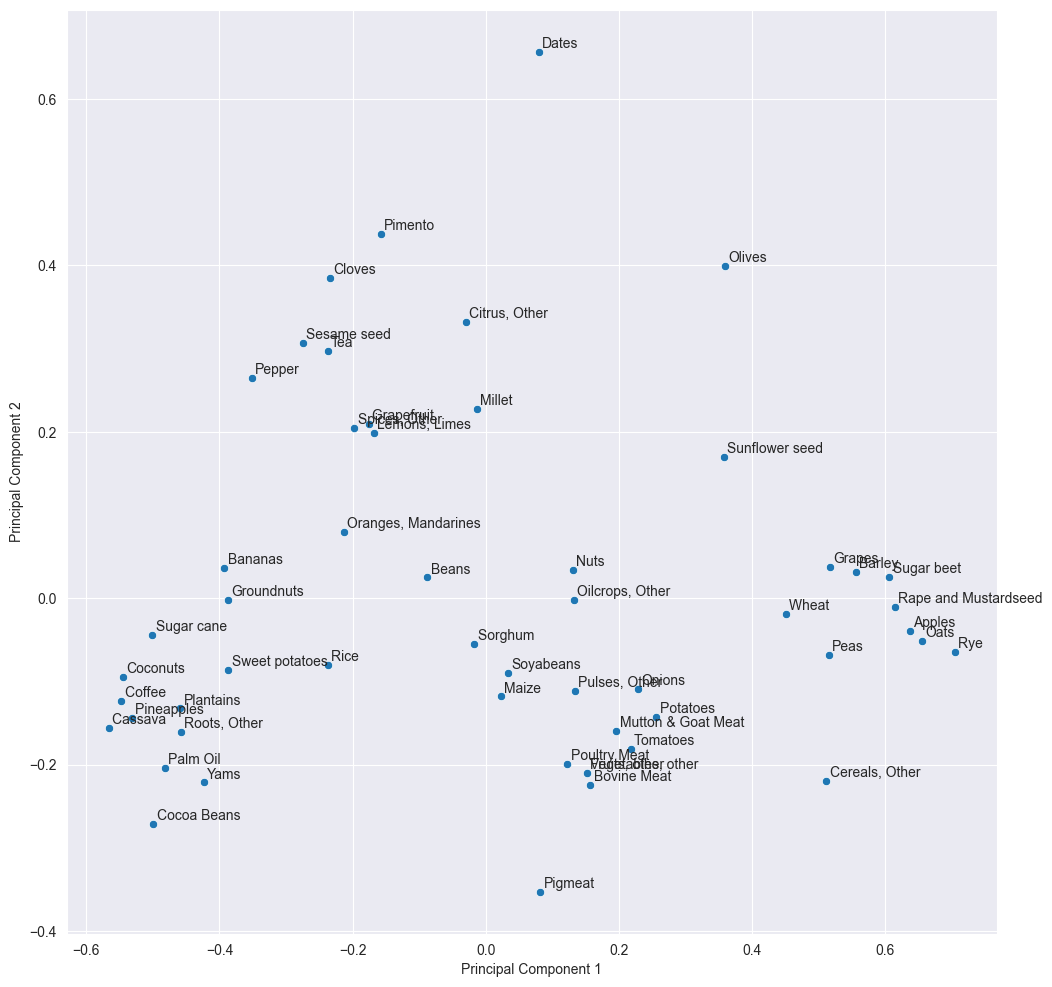

In [228]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="pc1", y="pc2",
    data=principal_comm_Df,
    legend="auto"
)
for i in range(principal_comm_Df.shape[0]):
    plt.text(x=principal_comm_Df.pc1[i]+0.005,y=principal_comm_Df.pc2[i]+0.005,s=principal_comm_Df.label[i], 
             fontdict=dict(size=10))
    
plt.xlabel("Principal Component 1")    #x label
plt.ylabel("Principal Component 2")  #y label
plt.show()


We can see from this PCA that similar commodities are clustering together (meats, tropical crops such as coconuts/coffee/pineapples etc.).  This is also reflected in our commodity cosine similarity index we have generated. What other interesting clusters can you find in this PCA?

#### Part 1B: Admin-Admin Similarities

Similar to above, lets generate the cosine similarities of which admin units are most alike to each other

In [240]:
DfMatrix2 = pd.pivot_table(data, values='grown', columns='admin_id', index='commodity')
DfMatrix2 = DfMatrix2.fillna(0)
DfResetted2 = DfMatrix2.reset_index().rename_axis(None, axis=1)
dfAdmins = DfResetted2.drop('commodity', axis=1) 
dfAdminsNorm = dfAdmins/np.sqrt(np.square(dfAdmins).sum(axis=0))  
AdminAdminSim = dfAdminsNorm.transpose().dot(dfAdminsNorm) 
AdminTop10 = pd.DataFrame(index=AdminAdminSim.columns,columns=range(1,11))
for i in range(0,len(AdminAdminSim.columns)): AdminTop10.iloc[i,:10] = AdminAdminSim.iloc[0:,i].sort_values(ascending=False)[:10].index  
AdminTop10.head(10)

,1,2,3,4,5,6,7,8,9,10
AFG.10_1,AFG.10_1,AFG.25_1,AFG.11_1,AFG.7_1,AFG.6_1,AFG.5_1,AFG.3_1,AFG.33_1,AFG.32_1,AFG.31_1
AFG.11_1,AFG.10_1,AFG.25_1,AFG.11_1,AFG.7_1,AFG.6_1,AFG.5_1,AFG.3_1,AFG.33_1,AFG.32_1,AFG.31_1
AFG.12_1,AFG.12_1,AFG.23_1,AFG.24_1,AFG.18_1,AFG.15_1,AFG.1_1,AFG.22_1,AFG.34_1,AFG.17_1,AFG.4_1
AFG.13_1,AFG.13_1,AFG.8_1,AFG.22_1,AFG.34_1,AFG.17_1,AFG.4_1,AFG.19_1,AFG.24_1,AFG.15_1,AFG.18_1
AFG.14_1,AFG.10_1,AFG.25_1,AFG.11_1,AFG.7_1,AFG.6_1,AFG.5_1,AFG.3_1,AFG.33_1,AFG.32_1,AFG.31_1
AFG.15_1,AFG.24_1,AFG.15_1,AFG.18_1,AFG.1_1,AFG.34_1,AFG.17_1,AFG.22_1,AFG.12_1,AFG.19_1,AFG.4_1
AFG.16_1,AFG.10_1,AFG.25_1,AFG.11_1,AFG.7_1,AFG.6_1,AFG.5_1,AFG.3_1,AFG.33_1,AFG.32_1,AFG.31_1
AFG.17_1,AFG.34_1,AFG.17_1,AFG.22_1,AFG.24_1,AFG.15_1,AFG.18_1,AFG.1_1,AFG.4_1,AFG.19_1,AFG.13_1
AFG.18_1,AFG.24_1,AFG.15_1,AFG.18_1,AFG.1_1,AFG.34_1,AFG.17_1,AFG.22_1,AFG.12_1,AFG.19_1,AFG.4_1
AFG.19_1,AFG.19_1,AFG.4_1,AFG.34_1,AFG.22_1,AFG.17_1,AFG.24_1,AFG.15_1,AFG.1_1,AFG.18_1,AFG.8_1


An initial look through data shows that admin units within a country seem to be the most similar to each other.  Digging into the table, are there other interesting occurences?  Do similar types of countries (eg. geographically near, similar climates) appear? 
Write the top 10 admin-admin similarities to file

In [230]:
AdminTop10.to_excel("admin_admin_top10.xlsx")


We can also visualize the admin unit embeddings

In [231]:
df_tranposed2=dfAdminsNorm.transpose()
df_tranposed2.index.name = 'label'
df_tranposed2.reset_index(inplace=True)

pca_admin = PCA(n_components=2)
principalComponents_admin = pca_admin.fit_transform(df_tranposed2.iloc[:,1:])
principal_admin_Df = pd.DataFrame(data = principalComponents_admin
             , columns = ['pc1', 'pc2'])
principal_admin_Df['label'] = df_tranposed2['label']
principal_admin_Df.head(3000)

,pc1,pc2,label
0,-0.111689,0.249537,AFG.10_1
1,-0.111689,0.249537,AFG.11_1
2,-0.080687,-0.118136,AFG.12_1
3,-0.242317,-0.020863,AFG.13_1
4,-0.111689,0.249537,AFG.14_1
...,...,...,...
2995,0.267512,-0.084337,UGA.38_1
2996,0.267512,-0.084337,UGA.39_1
2997,0.285618,-0.093735,UGA.3_1
2998,0.285618,-0.093735,UGA.40_1


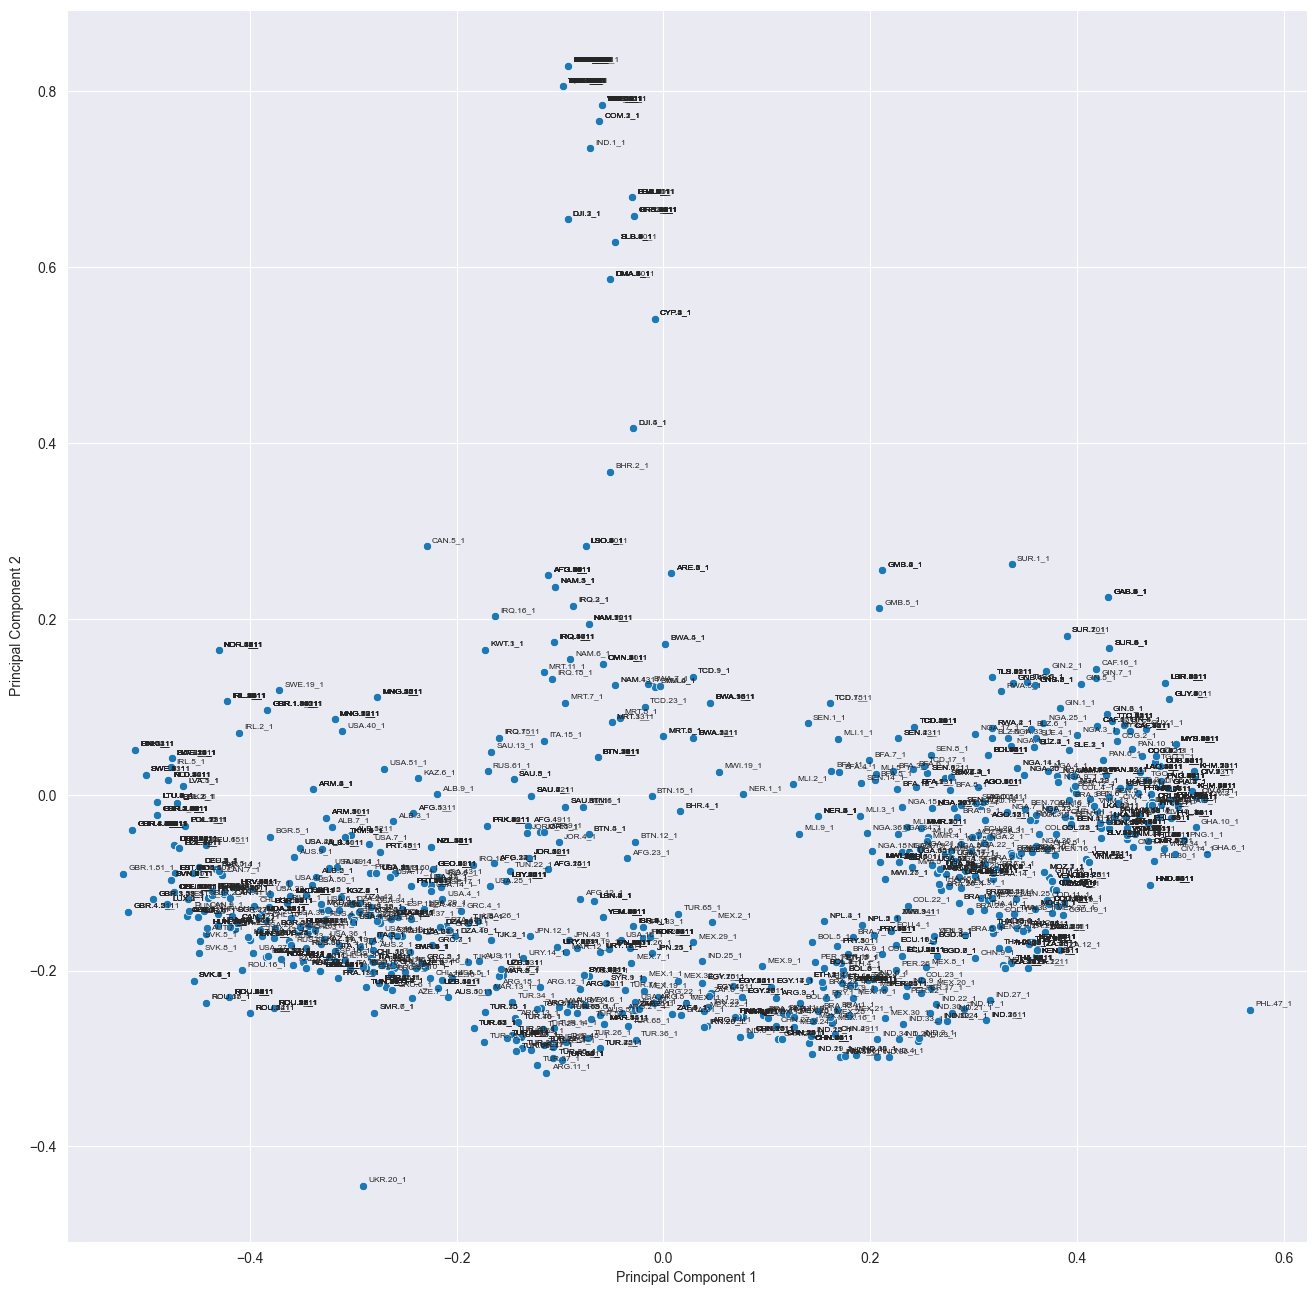

In [232]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="pc1", y="pc2",
    data=principal_admin_Df,
    legend="auto"
)
for i in range(principal_admin_Df.shape[0]):
    plt.text(x=principal_admin_Df.pc1[i]+0.005,y=principal_admin_Df.pc2[i]+0.005,s=principal_admin_Df.label[i], 
             fontdict=dict(size=6))
    
plt.xlabel("Principal Component 1")    #x label
plt.ylabel("Principal Component 2")  #y label
plt.show()

#### Part 1C: Admin-Commodity Recommendations
Our last task is our recommender system, where we want to recommend which commodities admin units could consider growing.  We will need the commodity similarity matrix, then will look at which commodities the admin unit grows and get the top 10 neighbours for each commodity.  Then we will calculate the admin's commodity growing history for each neighbour and calculate a similarity score for them.  In the end we will recommend 5 commodities with the highest score.

In [233]:
df=DfResetted 
df=df.fillna(0) 
df.head()
AdminItemSimilarity = pd.DataFrame(index=df.index,columns=df.columns)
AdminItemSimilarity.iloc[:,:1] = df.iloc[:,:1] 
AdminItemSimilarity.head()

,admin_id,Apples,Bananas,Barley,Beans,Bovine Meat,Cassava,"Cereals, Other","Citrus, Other",Cloves,...,"Spices, Other",Sugar beet,Sugar cane,Sunflower seed,Sweet potatoes,Tea,Tomatoes,"Vegetables, other",Wheat,Yams
0,AFG.10_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG.11_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG.12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG.13_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG.14_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate similarity scores through the functions we will create below: total runtime should be less than 1 minute

In [234]:
def getScore(history, similarities):
    return sum(history*similarities)/sum(similarities)


In [235]:
import warnings
warnings.filterwarnings('ignore')


for i in range(0,len(AdminItemSimilarity.index)): 
    for j in range(1,len(AdminItemSimilarity.columns)): 
        user = AdminItemSimilarity.index[i] 
        product = AdminItemSimilarity.columns[j]
        
        if df.loc[i][j] == 1: AdminItemSimilarity.loc[i][j] = 0 
        else: 
            ItemTop = ItemTop10.loc[product][1:10] 
            ItemTopSimilarity = ItemItemSim.loc[product].sort_values(ascending=False)[1:10] 
            AdminGrown = dfCommodities.loc[user,ItemTop] 
            
            AdminItemSimilarity.loc[i][j] = getScore(AdminGrown,ItemTopSimilarity) 
            
         


            
        

Let's take a peek at our newly generated recommendations

In [236]:
AdminItemSimilarity.head(10)

,admin_id,Apples,Bananas,Barley,Beans,Bovine Meat,Cassava,"Cereals, Other","Citrus, Other",Cloves,...,"Spices, Other",Sugar beet,Sugar cane,Sunflower seed,Sweet potatoes,Tea,Tomatoes,"Vegetables, other",Wheat,Yams
0,AFG.10_1,0.338799,0.109073,0,0.556639,0,0.106233,0.214844,0.110732,0.0,...,0.331562,0.219822,0.108486,0.558228,0.214816,0.110553,0.545994,0.66007,0,0.0
1,AFG.11_1,0.338799,0.109073,0,0.556639,0,0.106233,0.214844,0.110732,0.0,...,0.331562,0.219822,0.108486,0.558228,0.214816,0.110553,0.545994,0.66007,0,0.0
2,AFG.12_1,0,0.343374,0,0.892494,0,0.225649,0.438928,0,0.203437,...,0,0,0,0.889961,0.331064,0.446363,0.893469,0,0,0.103269
3,AFG.13_1,0,0.109073,0,0.892494,0,0.106233,0.438928,0.224275,0.0,...,0.44189,0,0.108486,0.889961,0.214816,0.110553,0.893469,0,0,0.0
4,AFG.14_1,0.338799,0.109073,0,0.556639,0,0.106233,0.214844,0.110732,0.0,...,0.331562,0.219822,0.108486,0.558228,0.214816,0.110553,0.545994,0.66007,0,0.0
5,AFG.15_1,0,0.343374,0,0.892494,0,0.225649,0.438928,0.335511,0.097645,...,0.551317,0,0,0.889961,0.331064,0.329341,0.893469,0,0,0.103269
6,AFG.16_1,0.338799,0.109073,0,0.556639,0,0.106233,0.214844,0.110732,0.0,...,0.331562,0.219822,0.108486,0.558228,0.214816,0.110553,0.545994,0.66007,0,0.0
7,AFG.17_1,0,0.225622,0,0.892494,0,0.106233,0.438928,0.335511,0.0,...,0.44189,0,0.208808,0.889961,0.214816,0.217151,0.893469,0,0,0.0
8,AFG.18_1,0,0.343374,0,0.892494,0,0.225649,0.438928,0.335511,0.097645,...,0.551317,0,0,0.889961,0.331064,0.329341,0.893469,0,0,0.103269
9,AFG.19_1,0,0.225622,0,0.892494,0,0.106233,0.438928,0.335511,0.0,...,0.44189,0.453022,0.208808,0.889961,0.214816,0.217151,0.893469,0,0,0.0


Let's convert this into the top 5 recommendations of new commodities for each admin unit and take a look

In [237]:
AdminItemRecommend = pd.DataFrame(index=AdminItemSimilarity.index, columns=['Admin_id','1','2','3','4','5']) 
AdminItemRecommend.iloc[0:,0] = AdminItemSimilarity.iloc[:,0]
for i in range(0,len(AdminItemSimilarity.index)):
    AdminItemRecommend.iloc[i,1:] = AdminItemSimilarity.iloc[i,1:].sort_values(ascending=False).iloc[0:5,].index.transpose()
    
AdminItemRecommend.head(100)

    

,Admin_id,1,2,3,4,5
0,AFG.10_1,"Fruits, other","Vegetables, other",Onions,Sunflower seed,Pigmeat
1,AFG.11_1,"Fruits, other","Vegetables, other",Onions,Sunflower seed,Pigmeat
2,AFG.12_1,Tomatoes,Beans,Pigmeat,Sunflower seed,Sorghum
3,AFG.13_1,Tomatoes,Beans,Pigmeat,Sunflower seed,"Oilcrops, Other"
4,AFG.14_1,"Fruits, other","Vegetables, other",Onions,Sunflower seed,Pigmeat
...,...,...,...,...,...,...
95,ARM.10_1,Sunflower seed,"Oilcrops, Other",Soyabeans,Sorghum,Peas
96,ARM.11_1,Sunflower seed,"Oilcrops, Other",Soyabeans,Sorghum,Peas
97,ARM.1_1,"Oilcrops, Other",Nuts,Sorghum,Sunflower seed,Soyabeans
98,ARM.2_1,"Oilcrops, Other",Nuts,Sorghum,Sunflower seed,Soyabeans


This looks interesting, we can see that for these Afghan provinces the recommendations mostly make sense, including for pork, which is culturally not consumed and would explain why its not a commodity grown in the country. Looking through the recommendations, what else stands out? 

In [238]:
AdminItemRecommend.to_excel("admin_comm_recommend.xlsx")
